# Triplet Loss with Faces -- Various tests

## Initialization

In [ ]:
# !pip install torch

In [ ]:
# !pip install mat73

In [ ]:
# !pip install wandb -qqq
# import wandb

In [ ]:
# !git clone https://github.com/mgornet/CNPEN

### Check device

In [ ]:
!nvidia-smi

### Import Librairies

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter
from typing import Callable
import itertools
import mat73
import pandas as pd
import re

import sys
import os
import tarfile

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve, \
precision_recall_curve, accuracy_score, f1_score
from scipy import optimize

import wandb

In [2]:
%cd ./files/

from triplet import TripletGenerator, TripletLearner, TripletLoss, TripletLossRaw, distance
from builder import create_dataframe, from_tensor_to_numpy, from_numpy_to_tensor, extend_dataframe
from prints import print_img, print_img_from_path, print_img_from_id, \
print_img_from_classid, print_from_gen, print_from_gen2, print_pair, print_hist_loss, \
print_hist_dist, print_hist_dist_zoom, print_img_category, \
print_roc, print_logistic_regression, print_prec_recall
from test_train_loops import training, testing, adaptative_train, compute_distances
from classification import authentification_img, predict, build_df_fairness, \
triplet_acc

/home/mgornet/Bureau/Code/CNPEN/files


In [3]:
!pwd

/home/mgornet/Bureau/Code/CNPEN/files


## Generate Data

### Create dataframe

In [4]:
URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME)

if not op.exists("lfw"):
    print('Extracting image files...')
    tar = tarfile.open("lfw-deepfunneled.tgz")
    tar.extractall("lfw")
    tar.close()

In [5]:
PATH = "lfw/lfw-deepfunneled/"

In [6]:
tic = perf_counter()
df_init, all_imgs = create_dataframe()
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

Number of individuals:  5749
Number of total images:  13233
images weigh  0.57 GB
DataFrame creation: 0.7 min


In [7]:
tic = perf_counter()
df = extend_dataframe(df_init)
toc = perf_counter()
print(f"DataFrame extention: {((toc - tic)/60):.1f} min")

DataFrame extention: 0.1 min


In [8]:
df

,Classid,Name,Path,Male,Asian,White,Black,Baby,Child,Youth,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13228,5744,Zorica_Radovic,Zorica_Radovic/Zorica_Radovic_0001.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
13229,5745,Zulfiqar_Ahmed,Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
13230,5746,Zumrati_Juma,Zumrati_Juma/Zumrati_Juma_0001.jpg,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
13231,5747,Zurab_Tsereteli,Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [9]:
df.describe()

,Classid,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
count,13233.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,...,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000,13143.000000
mean,2828.386005,0.774633,0.076771,0.747927,0.042608,0.004489,0.049304,0.163357,0.101803,0.213726,...,0.507038,0.408202,0.534429,0.155672,0.133303,0.343529,0.655482,0.139770,0.636384,0.204367
std,1642.531642,0.417840,0.266238,0.434220,0.201980,0.066853,0.216510,0.369705,0.302401,0.409951,...,0.499969,0.491520,0.498832,0.362558,0.339915,0.474904,0.475229,0.346762,0.481058,0.403254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1507.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2688.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,4243.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,5748.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.columns

Index(['Classid', 'Name', 'Path', 'Male', 'Asian', 'White', 'Black', 'Baby',
       'Child', 'Youth', 'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair',
       'Brown Hair', 'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses',
       'Mustache', 'Smiling', 'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting',
       'Flash', 'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair',
       'Straight Hair', 'Receding Hairline', 'Bangs', 'Sideburns',
       'Fully Visible Forehead', 'Partially Visible Forehead',
       'Obstructed Forehead', 'Bushy Eyebrows', 'Arched Eyebrows',
       'Narrow Eyes', 'Eyes Open', 'Big Nose', 'Pointy Nose', 'Big Lips',
       'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open',
       'Teeth Not Visible', 'No Beard', 'Goatee', 'Round Jaw', 'Double Chin',
       'Wearing Hat', 'Oval Face', 'Square Face', 'Round Face', 'Color Photo',
       'Posed Photo', 'Attractive Man', 'Attractive Woman', 'Indian',
       'Gray Hair', 'Bags Under Eyes', 'Heavy Makeup', 'Rosy

### Build sets, generators and network

In [11]:
num_classes = len(df.Classid.unique())
print("Number of individuals: ", num_classes)

Number of individuals:  5749


In [12]:
indiv_min = df.Classid.min()
split_train_valid = int(num_classes * 0.75)
split_train_test = int(num_classes * 0.8)
indiv_max = df.Classid.max()

In [13]:
print(f"Train set from indiv {indiv_min} to {split_train_valid-1}")
print(f"Valid set from indiv {split_train_valid} to {split_train_test-1}")
print(f"Test set from indiv {split_train_test} to {indiv_max}")

Train set from indiv 0 to 4310
Valid set from indiv 4311 to 4598
Test set from indiv 4599 to 5748


In [14]:
df_train = df[df.Classid<split_train_valid]
df_valid = df[(df.Classid>=split_train_valid)&(df.Classid<split_train_test)]
df_test = df[df.Classid>=split_train_test]

In [15]:
print("Number of training images: ", len(df_train))
print("Number of validation images: ", len(df_valid))
print("Number of testing images: ", len(df_test))
print("Number of total images: ", len(df_train)+len(df_valid)+len(df_test))
print("len original: ", len(df))

Number of training images:  10060
Number of validation images:  586
Number of testing images:  2587
Number of total images:  13233
len original:  13233


In [16]:
print("Number of individuals in the training set: ", len(df_train.Classid.unique()))
print("Number of individuals in the validation set: ", len(df_valid.Classid.unique()))
print("Number of individuals in the testing set: ", len(df_test.Classid.unique()))

Number of individuals in the training set:  4311
Number of individuals in the validation set:  288
Number of individuals in the testing set:  1150


In [17]:
value_count = df_train.Classid.value_counts()
print("Number of individuals with more than one image in the training set: ", len(value_count[value_count.values>1]))
value_count = df_valid.Classid.value_counts()
print("Number of individuals with more than one image in the validation set: ", len(value_count[value_count.values>1]))
value_count = df_test.Classid.value_counts()
print("Number of individuals with more than one image in the testing set: ", len(value_count[value_count.values>1]))

Number of individuals with more than one image in the training set:  1267
Number of individuals with more than one image in the validation set:  79
Number of individuals with more than one image in the testing set:  334


In [18]:
BATCH_SIZE = 128 # 128
BATCH_VALID_SIZE = 8 #128 #8
BATCH_TEST_SIZE = 32 #128 #32

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = TripletLearner(base_channels=32, dropout=0)
model.to(device)

lr = 1e-3/2 # 1e-3/2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150,200,250,300,350,400,450], gamma=0.5) #[300,400,500,600,700,800,900]

margin = 0.2
criterion = TripletLoss(margin)
criterion_test = TripletLossRaw(margin)

epochs = 500

In [20]:
gen_train = TripletGenerator(df_train, all_imgs, BATCH_SIZE, device, model, margin, transform = True)
train_loader = DataLoader(gen_train, batch_size=None, shuffle=True)

gen_valid = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
valid_loader = DataLoader(gen_valid, batch_size=None, shuffle=True)

gen_test = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin)
test_loader = DataLoader(gen_test, batch_size=None, shuffle=True)

/home/mgornet/Bureau/Code/CNPEN/files/triplet.py:253: UserWarning: Number of unique identities with more than 2 pictures (1267) is not divisible by batch_size (128). Remainder: 115
  warnings.warn(
/home/mgornet/Bureau/Code/CNPEN/files/triplet.py:253: UserWarning: Number of unique identities with more than 2 pictures (79) is not divisible by batch_size (8). Remainder: 7
  warnings.warn(
/home/mgornet/Bureau/Code/CNPEN/files/triplet.py:253: UserWarning: Number of unique identities with more than 2 pictures (334) is not divisible by batch_size (32). Remainder: 14
  warnings.warn(


### Verify shapes

In [21]:
# Shape of the generator

print(len(gen_train))
print(len(gen_train[0]))
print(gen_train[0][0].shape)

9
3
torch.Size([128, 3, 60, 60])


In [22]:
# Shape of the loader

print(len(train_loader))
print(train_loader)

9


## Test printing functions

### Basic test prints

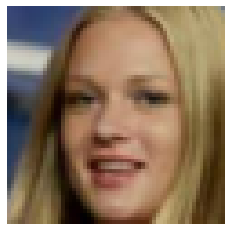

In [23]:
# Print an image from its path

print_img_from_path(df.iloc[0].Path)

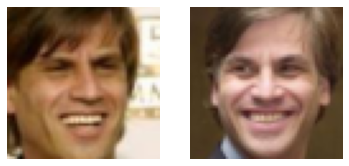

In [24]:
# Print an image from a certain identity

print_img_from_classid(df,7)

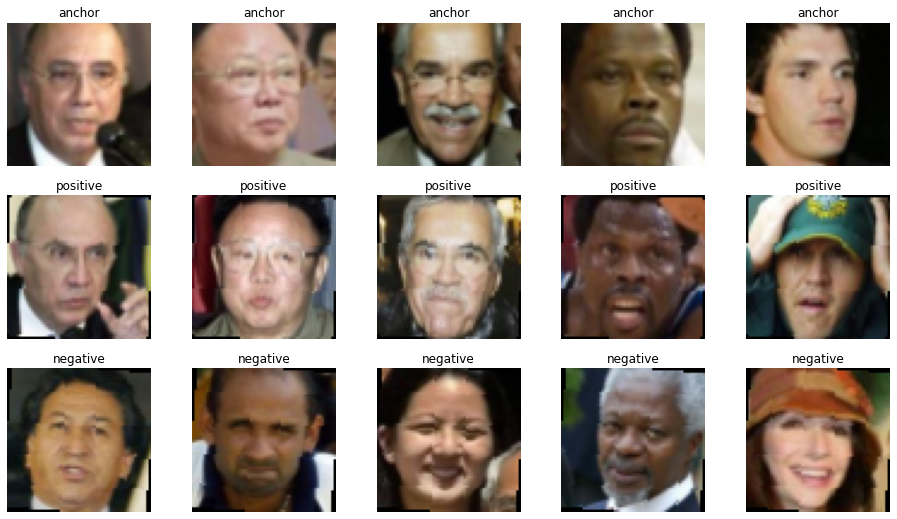

In [25]:
# Print a few images from the train generator

print_from_gen(gen_train,0)

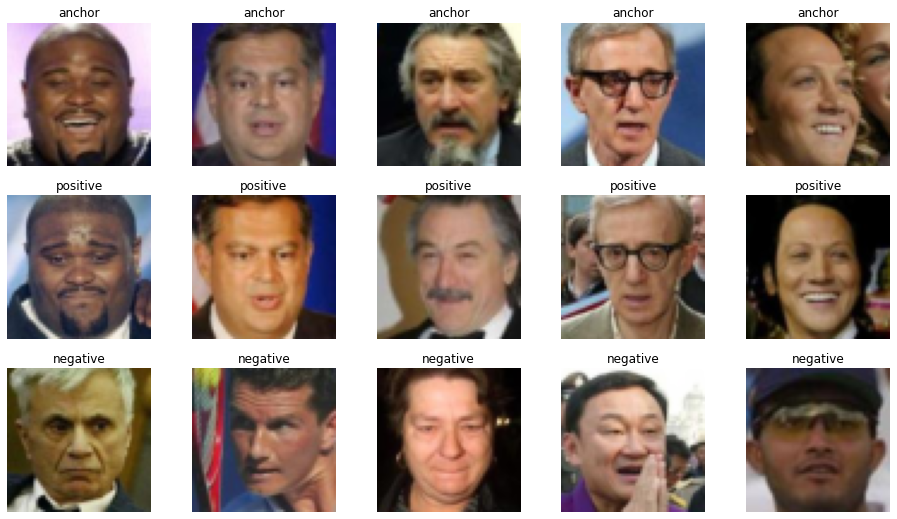

In [26]:
# Print a few images from the test generator

print_from_gen(gen_test,0)

In [27]:
# Print all the images of a batch from the train generator (warning: will print a lot of images)

# print_from_gen2(gen_valid)

### Test Augmentation

In [28]:
xa,xp,xn = gen_test[0]

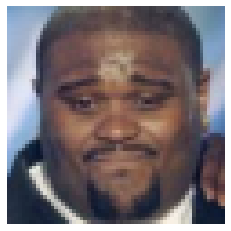

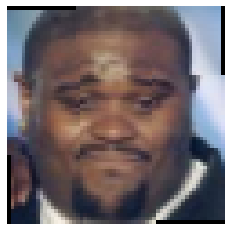

In [29]:
x = gen_train.apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

In [30]:
apply_augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([
            transforms.RandomRotation((-5,5))],
        p=0.95),
        transforms.RandomApply([
            transforms.RandomResizedCrop(size=60, scale=(0.7,0.7), ratio=(1.,1.))],
        p=0.95),
        # transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    ]
)

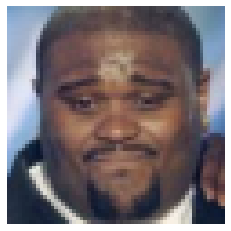

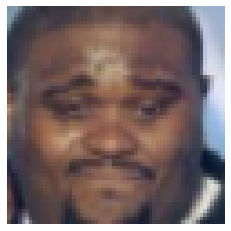

In [31]:
x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

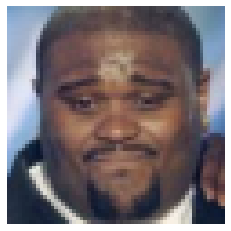

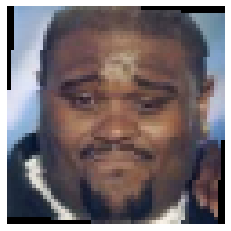

In [32]:
apply_augmentation = transforms.Compose([transforms.RandomRotation((-5,-5))])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

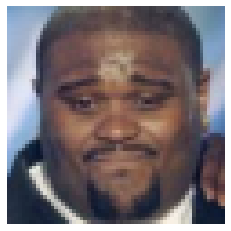

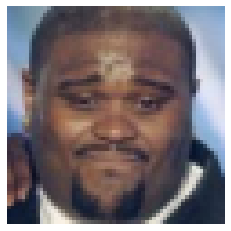

In [33]:
apply_augmentation = transforms.Compose([transforms.RandomHorizontalFlip(p=1)])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

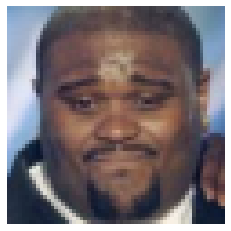

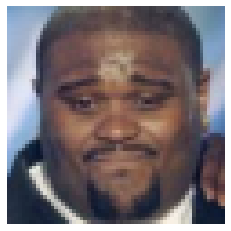

In [34]:
apply_augmentation = transforms.Compose([transforms.RandomResizedCrop(size=60, scale=(0.8,1.1), ratio=(1.,1.))])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

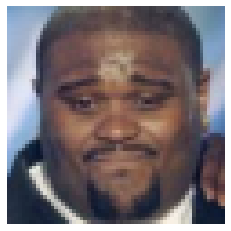

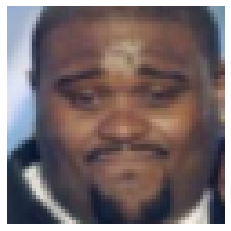

In [35]:
apply_augmentation = transforms.Compose([transforms.RandomResizedCrop(size=60, scale=(0.8,0.8))])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

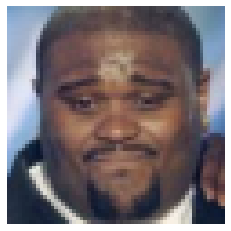

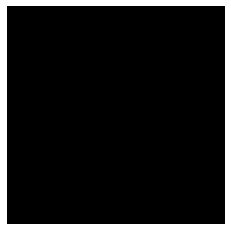

In [36]:
apply_augmentation = transforms.Compose([transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25)])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

Original image: between 6.253911972045898 and 250.50033569335938


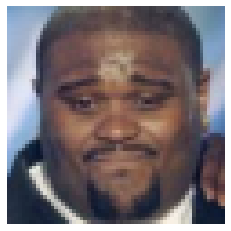

Normalized image: between 0.024525145068764687 and 0.9823542833328247


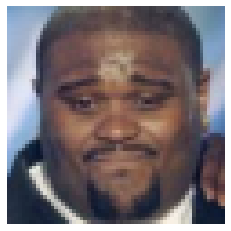

Back to original image: between 6.25391149520874 and 250.5003204345703


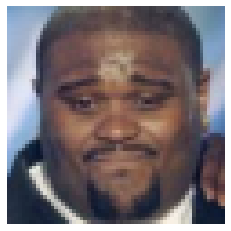

In [37]:
apply_augmentation = transforms.Compose([transforms.Normalize(mean=[0,0,0],std=[255,255,255])])

x = apply_augmentation(xa[0])
print(f'Original image: between {xa[0].min()} and {xa[0].max()}')
print_img(from_tensor_to_numpy(xa[0])/255)
print(f'Normalized image: between {x.min()} and {x.max()}')
print_img(from_tensor_to_numpy(x))

apply_augmentation_inverse = transforms.Compose([transforms.Normalize(mean=[0,0,0],std=[1/255,1/255,1/255])])

y = apply_augmentation_inverse(x)
print(f'Back to original image: between {y.min()} and {y.max()}')
print_img(from_tensor_to_numpy(y)/255)

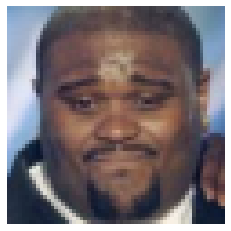

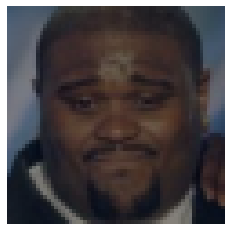

In [279]:
apply_augmentation = transforms.Compose([
    transforms.Normalize(mean=[0,0,0],std=[255,255,255]),
    transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1),
    transforms.Normalize(mean=[0,0,0],std=[1/255,1/255,1/255])
])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

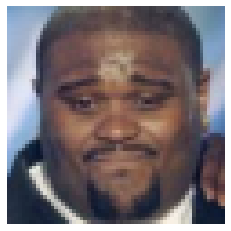

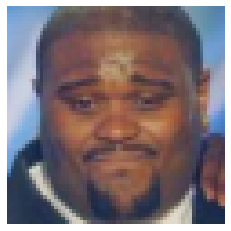

In [220]:
apply_augmentation = transforms.Compose([
    transforms.Normalize(mean=[0,0,0],std=[255,255,255]),
    transforms.ColorJitter(brightness=0.1, contrast=0.7, saturation=0.7),
    transforms.Normalize(mean=[0,0,0],std=[1/255,1/255,1/255])
])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

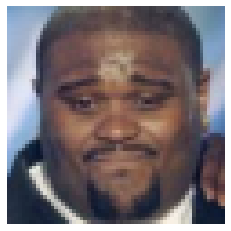

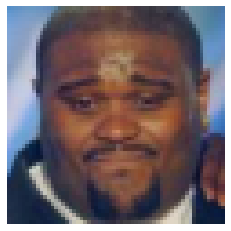

In [133]:
apply_augmentation = transforms.Compose([
    transforms.Normalize(mean=[0,0,0],std=[255,255,255]),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.7),
    transforms.Normalize(mean=[0,0,0],std=[1/255,1/255,1/255])
])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

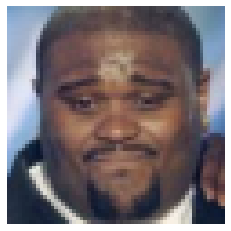

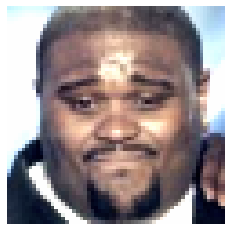

In [179]:
apply_augmentation = transforms.Compose([
    transforms.Normalize(mean=[0,0,0],std=[255,255,255]),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.Normalize(mean=[0,0,0],std=[1/255,1/255,1/255])
])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

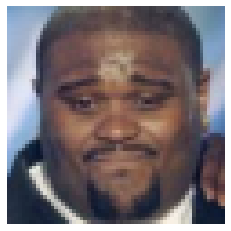

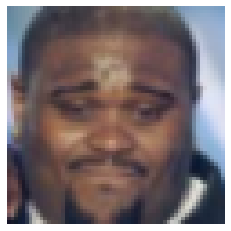

In [39]:
apply_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomResizedCrop(size=60, scale=(0.8,1.), ratio=(0.95,1.05))],
    p=0.9),
    transforms.RandomApply([
        transforms.Compose([
            transforms.Normalize(mean=[0,0,0],std=[255,255,255]),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            transforms.Normalize(mean=[0,0,0],std=[1/255,1/255,1/255])
        ]),],
    p=0.1),
    transforms.RandomApply([
        transforms.RandomRotation((-5,5))],
    p=0.7),
])

x = apply_augmentation(xa[0])
print_img(from_tensor_to_numpy(xa[0])/255)
print_img(from_tensor_to_numpy(x)/255)

### Test Categories

#### Supposed race

In [ ]:
print_img_category(all_imgs, df, 'White')

In [ ]:
print_img_category(all_imgs, df, 'White', inverse=True)

In [ ]:
print_img_category(all_imgs, df, 'Black')

In [ ]:
print_img_category(all_imgs, df, 'Asian')

In [ ]:
print_img_category(all_imgs, df, 'Indian')

#### Supposed gender

In [ ]:
print_img_category(all_imgs, df, 'Male')

In [ ]:
print_img_category(all_imgs, df, 'Male', inverse=True)

#### Supposed age category

In [ ]:
print_img_category(all_imgs, df, 'Baby')

In [ ]:
print_img_category(all_imgs, df, 'Baby', inverse=True)

In [ ]:
print_img_category(all_imgs, df, 'Child')

In [ ]:
print_img_category(all_imgs, df, 'Youth')

In [ ]:
print_img_category(all_imgs, df, 'Middle Aged')

In [ ]:
print_img_category(all_imgs, df, 'Senior')

#### Accessories

In [ ]:
print_img_category(all_imgs, df, 'Wearing Hat')

In [ ]:
print_img_category(all_imgs, df, 'Eyeglasses')

In [ ]:
print_img_category(all_imgs, df, 'Sunglasses')

In [ ]:
print_img_category(all_imgs, df, 'Sunglasses', inverse=True)

#### Hair(s)

In [ ]:
print_img_category(all_imgs, df, 'No Beard')

In [ ]:
print_img_category(all_imgs, df, 'No Beard', inverse=True)

In [ ]:
print_img_category(all_imgs, df, 'Mustache')

## Other tests

### Explore df

In [ ]:
df.describe()

In [ ]:
value_count = df.Classid.value_counts()
value_count

In [ ]:
df.loc[1871]

In [ ]:
print_img(from_tensor_to_numpy(all_imgs[1871])/255)

### Test the valid loader

In [ ]:
valid_list = list(valid_loader)
for _ in range(2):
    new_valid = list(valid_loader)
    valid_list[0][0] = torch.cat((valid_list[0][0],new_valid[0][0]), axis=0)
    valid_list[0][1] = torch.cat((valid_list[0][1],new_valid[0][1]), axis=0)
    valid_list[0][2] = torch.cat((valid_list[0][2],new_valid[0][2]), axis=0)

In [ ]:
print_img(from_tensor_to_numpy(valid_list[0][0][78])/255)
print_img(from_tensor_to_numpy(valid_list[0][1][78])/255)
print_img(from_tensor_to_numpy(valid_list[0][2][78])/255)

In [ ]:
print_img(from_tensor_to_numpy(valid_list[0][0][79])/255)
print_img(from_tensor_to_numpy(valid_list[0][1][79])/255)
print_img(from_tensor_to_numpy(valid_list[0][2][79])/255)

### Print the histogram inductive bias

In [ ]:
model = TripletLearner(base_channels=32)
model.eval()

In [ ]:
device = torch.device('cpu')

gen = TripletGenerator(df_train, all_imgs, BATCH_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

pos_dist, neg_dist, _ = compute_distances(loader, device, model)

In [ ]:
print_hist_dist_zoom(pos_dist,neg_dist,zoom=3e-3)

### Print the histogram of initial loss

In [ ]:
model = TripletLearner(base_channels=32)
model.eval()

In [ ]:
loss = testing(train_loader, device, model, criterion_test)

In [ ]:
print_hist_loss(loss)

### Print the learning rate schedule

In [ ]:
lrs = []

for epoch in range(1000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

In [ ]:
plt.figure()
plt.plot(range(1000),lrs, color='red')
plt.xlabel('Number of epochs')
plt.ylabel('Learning rate value')
plt.show()

## Test Classification

In [ ]:
model = TripletLearner(base_channels=32)
model.load_state_dict(torch.load("../models/without_jitter_and_p.pth",map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

In [ ]:
# Build THRESHOLD (for details, see the notebook "determine_threshold")

gen = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

list_loader = []
for _ in range(10):
    list_loader.extend(list(loader))

pos_dist, neg_dist, _ = compute_distances(list_loader, device, model) #loader

y_pos = [1 for _ in range(len(pos_dist))]
y_neg = [0 for _ in range(len(neg_dist))]

y = y_pos + y_neg
X = pos_dist + neg_dist
Xmoins = np.array(X)*(-1)
Xlogistic = np.array(Xmoins).reshape(-1,1)

clf = LogisticRegression(random_state=0).fit(Xlogistic, y)

THRESHOLD = (clf.intercept_/clf.coef_)[0,0]
print("THRESHOLD with logistic regression:", THRESHOLD)

### Test random pairs

In [ ]:
# Print a random pair classified as "different"

print("ARE SUPPOSED TO BE ALWAYS DIFFERENT")

Xa, Xp, Xn = next(iter(loader))

rdm = random.randint(0,len(Xa)-1)

bin = authentification_img(Xa[rdm], Xn[rdm], device, model, THRESHOLD, verbose = True)

print_pair(Xa[rdm], Xn[rdm])

if bin==1 :
    print("Same person")
else :
    print("Different people")

In [ ]:
# Print a random pair classified as "same"

print("ARE SUPPOSED TO BE ALWAYS THE SAME")

Xa, Xp, Xn = next(iter(loader))

rdm = random.randint(0,len(Xa)-1)

bin = authentification_img(Xa[rdm], Xp[rdm], device, model, THRESHOLD, verbose = True)

print_pair(Xa[rdm], Xp[rdm])

if bin==1 :
    print("Prediction: Same person")
else :
    print("Prediction: Different people")

### Print extremes errors

In [ ]:
len(list_loader), len(list_loader[0]), list_loader[0][0].shape

In [ ]:
# Reorganize images to fetch them more easily

img_classif = []
for i in range(3):
    img_classif.append(torch.cat([list_loader[j][i] for j in range(len(list_loader))], 0))

In [ ]:
len(img_classif), img_classif[0].shape

In [ ]:
print(len(img_classif))
print(img_classif[0].shape)

In [ ]:
# Positive pair with hight and low distance

pos_dist2 = pos_dist.copy()
pos_dist3 = pos_dist.copy()

dist_max_list, id_max_list = [], []
dist_min_list, id_min_list = [], []

for _ in range(5) :
    
    dist_max, id_max = max(pos_dist2), np.argmax(np.array(pos_dist2))
    dist_max_list.append(dist_max)
    id_max_list.append(id_max)
    pos_dist2.pop(id_max)
    
    dist_min, id_min = min(pos_dist3), np.argmin(np.array(pos_dist3))
    dist_min_list.append(dist_min)
    id_min_list.append(id_min)
    pos_dist3.pop(id_min)

In [ ]:
print("SAME IDENTITY WITH HIGH DISTANCES")
print("MORE LIKELY TO BE FALSE NEGATIVES")
#  TRUE SAME ID WITH HIGH PREDICTED DISTANCES

for dist,id_img in zip(dist_max_list,id_max_list):
    print("Distance:", dist)
    anchor = img_classif[0][id_img]
    positive = img_classif[1][id_img]
    print_pair(anchor, positive)

In [ ]:
print("SAME IDENTITY WITH LOW DISTANCES")
print("MORE LIKELY TO BE TRUE POSITIVES")

for dist,id_img in zip(dist_min_list,id_min_list):
    print("Distance:", dist)
    anchor = img_classif[0][id_img]
    positive = img_classif[1][id_img]
    print_pair(anchor, positive)

In [ ]:
# Negative pair with hight and low distance

neg_dist2 = neg_dist.copy()
neg_dist3 = neg_dist.copy()

dist_max_list, id_max_list = [], []
dist_min_list, id_min_list = [], []

for _ in range(5) :
    
    dist_max, id_max = max(neg_dist2), np.argmax(np.array(neg_dist2))
    dist_max_list.append(dist_max)
    id_max_list.append(id_max)
    neg_dist2.pop(id_max)
    
    dist_min, id_min = min(neg_dist3), np.argmin(np.array(neg_dist3))
    dist_min_list.append(dist_min)
    id_min_list.append(id_min)
    neg_dist3.pop(id_min)

In [ ]:
print("DIFFERENT IDENTITIES WITH LOW DISTANCES")
print("MORE LIKELY TO BE FALSE POSITIVES")

for dist,id_img in zip(dist_min_list,id_min_list):
    print("Distance:", dist)
    anchor = img_classif[0][id_img]
    negative = img_classif[2][id_img]
    print_pair(anchor, negative)

In [ ]:
print("DIFFERENT IDENTITIES WITH HIGH DISTANCES")
print("MORE LIKELY TO BE TRUE NEGATIVES")

for dist,id_img in zip(dist_max_list,id_max_list):
    print("Distance:", dist)
    anchor = img_classif[0][id_img]
    negative = img_classif[2][id_img]
    print_pair(anchor, negative)

### Fairness

In [ ]:
# Build THRESHOLD (for details, see the notebook "determine_threshold")

gen = TripletGenerator(df_valid, all_imgs, BATCH_VALID_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

list_loader = []
for _ in range(10):
    list_loader.extend(list(loader))

pos_dist, neg_dist, _ = compute_distances(list_loader, device, model) #loader

y_pos = [1 for _ in range(len(pos_dist))]
y_neg = [0 for _ in range(len(neg_dist))]

y = y_pos + y_neg
X = pos_dist + neg_dist
Xmoins = np.array(X)*(-1)
Xlogistic = np.array(Xmoins).reshape(-1,1)

clf = LogisticRegression(random_state=0).fit(Xlogistic, y)

THRESHOLD = (clf.intercept_/clf.coef_)[0,0]
print("THRESHOLD with logistic regression:", THRESHOLD)

In [ ]:
gen = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin, return_id=True)
tic = perf_counter()
df_fairness = build_df_fairness(all_imgs, df_test, gen, 20, device, model, THRESHOLD)
toc = perf_counter()
print(f"DataFrame creation: {((toc - tic)/60):.1f} min")

In [ ]:
my_img = all_imgs[df_fairness[df_fairness.A_Male==0].id_A.iloc[3]]

In [ ]:
print_img(from_tensor_to_numpy(my_img)/255)

In [ ]:
my_img = all_imgs[list(df_fairness[df_fairness.A_Male==0].id_A)]

In [ ]:
for k in range(10):
    print_img(from_tensor_to_numpy(my_img[k])/255)

## My images

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = TripletLearner(base_channels=32, dropout=0)
model.to(device)

lr = 1e-3/2 # 1e-3/2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300,400,500,600,700,800,900], gamma=0.5)

margin = 0.2
criterion = TripletLoss(margin)
criterion_test = TripletLossRaw(margin)

epochs = 1000

In [ ]:
model = TripletLearner(base_channels=32)
model.load_state_dict(torch.load("./models/without_jitter_and_p.pth",map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

In [ ]:
MY_IMGS_PATH = '../my_imgs/'

In [ ]:
df_my_imgs, all_my_imgs = create_dataframe(MY_IMGS_PATH)

In [ ]:
print_img(from_tensor_to_numpy(all_my_imgs[0])/255)

In [ ]:
# for i in range(len(all_my_imgs)):
#     print_img(from_tensor_to_numpy(all_my_imgs[i])/255)

In [ ]:
df_my_imgs

In [ ]:
print_img(from_tensor_to_numpy(all_my_imgs[19]/255))

In [ ]:
gen = TripletGenerator(df_my_imgs, all_my_imgs, 128, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

In [ ]:
Xa, Xp, Xn = next(iter(loader))

rdm = random.randint(0,len(Xa)-1)

bin = authentification_img(Xa[rdm], Xp[rdm], device, model, THRESHOLD, verbose = True)

if bin==1 :
    print("Prediction: Same person")
else :
    print("Prediction: Different people")
    
print_pair(Xa[rdm], Xp[rdm])

In [ ]:
Xa, Xp, Xn = next(iter(loader))

rdm = random.randint(0,len(Xa)-1)

bin = authentification_img(Xa[rdm], Xn[rdm], device, model, THRESHOLD, verbose = True)

if bin==1 :
    print("Prediction: Same person")
else :
    print("Prediction: Different people")
    
print_pair(Xa[rdm], Xn[rdm])

In [ ]:
def print_all_pairs_with_distances(df, all_imgs):
    list_paths = list(df.index)
    pos_pairs = list(itertools.combinations(list_paths,2))
    random.shuffle(pos_pairs)
    
    for pair in range(len(list_paths)):
        i,j = pos_pairs[pair]
        img1 = all_imgs[i]
        img2 = all_imgs[j]
        bin = authentification_img(img1, img2, device, model, THRESHOLD, verbose = True)

        if bin==1 :
            print("Prediction: Same person")
        else :
            print("Prediction: Different people")
            
        print_pair(img1, img2)

In [ ]:
print_all_pairs_with_distances(df_my_imgs[df_my_imgs.Classid==0], all_my_imgs)

In [ ]:
print_all_pairs_with_distances(df_my_imgs[df_my_imgs.Classid==1], all_my_imgs)

In [ ]:
print_all_pairs_with_distances(df_my_imgs[df_my_imgs.Classid==2], all_my_imgs)

### Precision with my images

In [ ]:
list_loader = []
for _ in range(50):
    list_loader.extend(list(loader))

In [ ]:
pos_dist, neg_dist, _ = compute_distances(list_loader, device, model) #loader

In [ ]:
print_hist_dist_zoom(pos_dist,neg_dist)

In [ ]:
y_pos = [1 for _ in range(len(pos_dist))]
y_neg = [0 for _ in range(len(neg_dist))]

y = y_pos + y_neg
X = pos_dist + neg_dist

Xmoins = np.array(X)*(-1)

fpr_dist, tpr_dist, thresholds_dist = roc_curve(y, Xmoins)
roc_auc_dist = auc(fpr_dist,tpr_dist)

precision_dist, recall_dist, thresholds_recall_dist = precision_recall_curve(y, Xmoins)
auc_s_dist = auc(recall_dist, precision_dist)

In [ ]:
print_roc(fpr_dist, tpr_dist, roc_auc_dist)
print_prec_recall(precision_dist, recall_dist, auc_s_dist)

In [ ]:
# Predict classification from THRESHOLD

y_pred_pos_bins, y_pred_neg_bins = predict(list_loader, device, model, THRESHOLD) #loader
y_pred_bins = y_pred_pos_bins + y_pred_neg_bins
triplet_accuracy = triplet_acc(list_loader, device, model)

print("Confusion Matrix Total")
print(confusion_matrix(y, y_pred_bins))
print("\n")
print("Accuracy score:",accuracy_score(y, y_pred_bins))
print("Triplets where d(A,P) < d(A,N): ",round(100*triplet_accuracy,1),"%")

### Precision with test images

In [ ]:
gen = TripletGenerator(df_test, all_imgs, BATCH_TEST_SIZE, device, model, margin)
loader = DataLoader(gen, batch_size=None, shuffle=True)

list_loader = []
for _ in range(10):
    list_loader.extend(list(loader))

pos_dist, neg_dist, _ = compute_distances(list_loader, device, model) #loader

y_pos = [1 for _ in range(len(pos_dist))]
y_neg = [0 for _ in range(len(neg_dist))]

y = y_pos + y_neg
X = pos_dist + neg_dist
Xmoins = np.array(X)*(-1)

fpr_dist, tpr_dist, thresholds_dist = roc_curve(y, Xmoins)
roc_auc_dist = auc(fpr_dist,tpr_dist)

precision_dist, recall_dist, thresholds_recall_dist = precision_recall_curve(y, Xmoins)
auc_s_dist = auc(recall_dist, precision_dist)

In [ ]:
print_hist_dist_zoom(pos_dist,neg_dist)

In [ ]:
print_roc(fpr_dist, tpr_dist, roc_auc_dist)
print_prec_recall(precision_dist, recall_dist, auc_s_dist)

In [ ]:
# Predict classification from THRESHOLD

y_pred_pos_bins, y_pred_neg_bins = predict(list_loader, device, model, THRESHOLD) #loader
y_pred_bins = y_pred_pos_bins + y_pred_neg_bins
triplet_accuracy = triplet_acc(list_loader, device, model)

print("Confusion Matrix Total")
print(confusion_matrix(y, y_pred_bins))
print("\n")
print("Accuracy score:",accuracy_score(y, y_pred_bins))
print("Triplets where d(A,P) < d(A,N): ",round(100*triplet_accuracy,1),"%")